# Capstone Phase 2 - ANN  
Exploration of Artificial Neural Networks

### Import some libraries we'll need

In [1]:
import joblib
import pandas as pd
import numpy as np
from sklearn import preprocessing
from zipfile import ZipFile

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

### Some Utility Stuff

In [10]:
def transform_data(df):
    no_labels = df.drop(['label', 'attack_cat'], axis=1)
    one_hot = pd.get_dummies(no_labels, columns=['proto', 'service', 'state'], prefix=['proto', 'service', 'state'])
    scaler = preprocessing.StandardScaler().fit(one_hot)
    standardized = scaler.transform(one_hot)
    std = pd.DataFrame(standardized, columns=one_hot.columns)

    labels = df['label'].copy()
    cats = df['attack_cat'].copy()
    
    return std, labels, cats

In [11]:
def plt_norm_confmat(model, X, y, title, fname=None, labels=None):
    fig, ax = plt.subplots(figsize=(7, 7))
    display = plot_confusion_matrix(model, X, y, display_labels=labels, cmap=plt.cm.Blues, 
                                    normalize='true', xticks_rotation='vertical', ax=ax)
    display.ax_.set_title(title)
    if fname is not None:
        file = './images/' + fname + '.png'
        plt.savefig(file, dpi=300, bbox_inches='tight')

In [12]:
def gen_metrics(y_train, y_pred):
    conf_mat = confusion_matrix(y_train, y_pred)
    class_rep = classification_report(y_train, y_pred, zero_division=0)
    rep_dict = classification_report(y_train, y_pred, zero_division=0, output_dict=True)
    acc = accuracy_score(y_train, y_pred)
    return conf_mat, class_rep, rep_dict, acc

### Load data and apply transformations

We need to upload the data file from our local drive.

In [4]:
from google.colab import files
uploaded = files.upload()

Saving UNSW_NB15 training and testing sets.zip to UNSW_NB15 training and testing sets.zip


Import the io library so we can load the file we uploaded.

In [5]:
import io

In [6]:
with ZipFile(io.BytesIO(uploaded['UNSW_NB15 training and testing sets.zip'])) as datasets_zip:
    # open each file and read in to a DataFrame
    with datasets_zip.open('UNSW_NB15_training-set.csv') as training_file:
        training_data = pd.read_csv(training_file, index_col='id')
    with datasets_zip.open('UNSW_NB15_testing-set.csv') as testing_file:
        testing_data = pd.read_csv(testing_file, index_col='id')

In [13]:
training_data_std, training_labels, training_cats = transform_data(training_data)
testing_data_std, testing_labels, testing_cats = transform_data(testing_data)

In [14]:
label_encoder = preprocessing.LabelEncoder()
y_train = label_encoder.fit_transform(training_cats)
y_test = label_encoder.fit_transform(testing_cats)

In [15]:
class_names = list(label_encoder.classes_)

### Load feature subsets

First upload the file from our local drive

In [18]:
features_pkl = files.upload() # joblib.load('./data/feature_subsets.pkl')

Saving feature_subsets.pkl to feature_subsets (1).pkl


In [19]:
feature_subsets = joblib.load('feature_subsets.pkl')

In [20]:
train_std_ig = training_data_std[feature_subsets['ig']].copy()
test_std_ig = testing_data_std[feature_subsets['ig']].copy()

train_std_anova = training_data_std[feature_subsets['anova']].copy()
test_std_anova = testing_data_std[feature_subsets['anova']].copy()

train_std_vt = training_data_std[feature_subsets['vt']].copy()
test_std_vt = testing_data_std[feature_subsets['vt']].copy()

train_std_mad = training_data_std[feature_subsets['mad']].copy()
test_std_mad = testing_data_std[feature_subsets['mad']].copy()

train_std_corr = training_data_std[feature_subsets['corr']].copy()
test_std_corr = testing_data_std[feature_subsets['corr']].copy()

train_std_rfe = training_data_std[feature_subsets['rfe']].copy()
test_std_rfe = testing_data_std[feature_subsets['rfe']].copy()

### Artificial Neural Network  
We'll start with a basic sequential model.

In [22]:
import tensorflow as tf
from tensorflow import keras

In [28]:
model = keras.models.Sequential([
                                 keras.layers.Input(shape=train_std_ig.shape[1:]),
                                 keras.layers.Dense(300, activation='relu'),
                                 keras.layers.Dense(100, activation='relu'),
                                 keras.layers.Dense(10, activation='softmax')
])

In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 300)               6300      
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
Total params: 37,410
Trainable params: 37,410
Non-trainable params: 0
_________________________________________________________________


In [30]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

In [31]:
hist = model.fit(train_std_ig, y_train, epochs=30, validation_split=0.2)

Epoch 1/30
4384/4384 [==============================] - 7s 2ms/step - loss: 1.0640 - accuracy: 0.6247 - val_loss: 0.4777 - val_accuracy: 0.8582
Epoch 2/30
4384/4384 [==============================] - 7s 2ms/step - loss: 0.7684 - accuracy: 0.7206 - val_loss: 0.4457 - val_accuracy: 0.8662
Epoch 3/30
4384/4384 [==============================] - 7s 2ms/step - loss: 0.7287 - accuracy: 0.7345 - val_loss: 0.4184 - val_accuracy: 0.8709
Epoch 4/30
4384/4384 [==============================] - 7s 2ms/step - loss: 0.7001 - accuracy: 0.7419 - val_loss: 0.4059 - val_accuracy: 0.8726
Epoch 5/30
4384/4384 [==============================] - 7s 2ms/step - loss: 0.6860 - accuracy: 0.7440 - val_loss: 0.3897 - val_accuracy: 0.8746
Epoch 6/30
4384/4384 [==============================] - 7s 2ms/step - loss: 0.6742 - accuracy: 0.7482 - val_loss: 0.3703 - val_accuracy: 0.8877
Epoch 7/30
4384/4384 [==============================] - 7s 2ms/step - loss: 0.6638 - accuracy: 0.7492 - val_loss: 0.3675 - val_accuracy:

In [33]:
import seaborn as sns

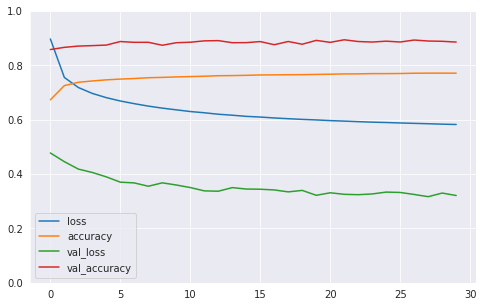

In [35]:
pd.DataFrame(hist.history).plot(figsize=(8, 5))
sns.set_style('darkgrid')
plt.ylim((0, 1))
plt.show()

Not terrible results for a quick test.  Of course we'll want to tune the hyper-parameters.  The traiing set is skewed so we should set `class_weight`.  
For comparison to the other models we'll want to train on each feature subset, but ultimately we want to see what we can do with the full set.